In [ ]:
!git clone https://github.com/stellargraph/stellargraph.git


Cloning into 'stellargraph'...
remote: Enumerating objects: 22627, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 22627 (delta 37), reused 61 (delta 20), pack-reused 22531
Receiving objects: 100% (22627/22627), 93.44 MiB | 18.36 MiB/s, done.
Resolving deltas: 100% (14721/14721), done.


In [ ]:
pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/stellargraph
  Preparing metadata (setup.py) ... done
ERROR: Package 'stellargraph' requires a different Python: 3.9.16 not in '<3.9.0,>=3.6.0'


In [ ]:
cd stellargraph

/content/stellargraph


In [ ]:
pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/stellargraph (from -r requirements.txt (line 4))
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.2/385.2 kB 18.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 528.1/528.1 kB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 22.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━

In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from stellargraph import StellarGraph
from stellargraph.datasets import IAEnronEmployees

%matplotlib inline

In [ ]:
dataset = IAEnronEmployees()
display(HTML(dataset.description))

full_graph, edges = dataset.load()

In [ ]:
# subset of edges to split
train_subset = 0.25
test_subset = 0.25

# number of edges to be kept in the graph
num_edges_graph = int(len(edges) * (1 - train_subset))

# keep older edges in graph, and predict more recent edges
edges_graph = edges[:num_edges_graph]
edges_other = edges[num_edges_graph:]

# split recent edges further to train and test sets
edges_train, edges_test = train_test_split(edges_other, test_size=test_subset)

print(
    f"Number of edges in graph: {len(edges_graph)}\n"
    f"Number of edges in training set: {len(edges_train)}\n"
    f"Number of edges in test set: {len(edges_test)}"
)

Number of edges in graph: 37929
Number of edges in training set: 9482
Number of edges in test set: 3161


In [ ]:
graph = StellarGraph(
    nodes=pd.DataFrame(index=full_graph.nodes()),
    edges=edges_graph,
    edge_weight_column="time",
)


AttributeError: ignored

In [ ]:
def positive_and_negative_links(g, edges):
    pos = list(edges[["source", "target"]].itertuples(index=False))
    neg = sample_negative_examples(g, pos)
    return pos, neg


def sample_negative_examples(g, positive_examples):
    positive_set = set(positive_examples)

    def valid_neg_edge(src, tgt):
        return (
            # no self-loops
            src != tgt
            and
            # neither direction of the edge should be a positive one
            (src, tgt) not in positive_set
            and (tgt, src) not in positive_set
        )

    possible_neg_edges = [
        (src, tgt) for src in g.nodes() for tgt in g.nodes() if valid_neg_edge(src, tgt)
    ]
    return random.sample(possible_neg_edges, k=len(positive_examples))


pos, neg = positive_and_negative_links(graph, edges_train)
pos_test, neg_test = positive_and_negative_links(graph, edges_test)

In [ ]:
print(
    f"{graph.info()}\n"
    f"Training examples: {len(pos)} positive links, {len(neg)} negative links\n"
    f"Test examples: {len(pos_test)} positive links, {len(neg_test)} negative links"
)

StellarGraph: Undirected multigraph
 Nodes: 151, Edges: 37929

 Node types:
  default: [151]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [37929]
        Weights: range=[9.2639e+08, 1.00583e+09], mean=9.87855e+08, std=1.664e+07
        Features: none
Training examples: 9482 positive links, 9482 negative links
Test examples: 3161 positive links, 3161 negative links


In [ ]:
num_walks_per_node = 10
walk_length = 80
context_window_size = 10

In [ ]:
num_cw = len(graph.nodes()) * num_walks_per_node * (walk_length - context_window_size + 1)

In [ ]:
from stellargraph.data import TemporalRandomWalk

temporal_rw = TemporalRandomWalk(graph)
temporal_walks = temporal_rw.run(
    num_cw=num_cw,
    cw_size=context_window_size,
    max_walk_length=walk_length,
    walk_bias="exponential",
)

print("Number of temporal random walks: {}".format(len(temporal_walks)))

Number of temporal random walks: 1818


In [ ]:
from gensim.models import Word2Vec

embedding_size = 128
temporal_model = Word2Vec(
    temporal_walks,
    vector_size=embedding_size,
    window=context_window_size,
    min_count=0,
    sg=1,
    workers=2,
    
)

In [ ]:
unseen_node_embedding = np.zeros(embedding_size)


def temporal_embedding(u):
    try:
        return temporal_model.wv[u]
    except KeyError:
        return unseen_node_embedding

In [ ]:
def plot_tsne(title, x, y=None):
    tsne = TSNE(n_components=2)
    x_t = tsne.fit_transform(x)

    plt.figure(figsize=(7, 7))
    plt.title(title)
    alpha = 0.7 if y is None else 0.5

    scatter = plt.scatter(x_t[:, 0], x_t[:, 1], c=y, cmap="jet", alpha=alpha)
    if y is not None:
        plt.legend(*scatter.legend_elements(), loc="lower left", title="Classes")

<ipython-input-15-2791b6888834>:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(x_t[:, 0], x_t[:, 1], c=y, cmap="jet", alpha=alpha)


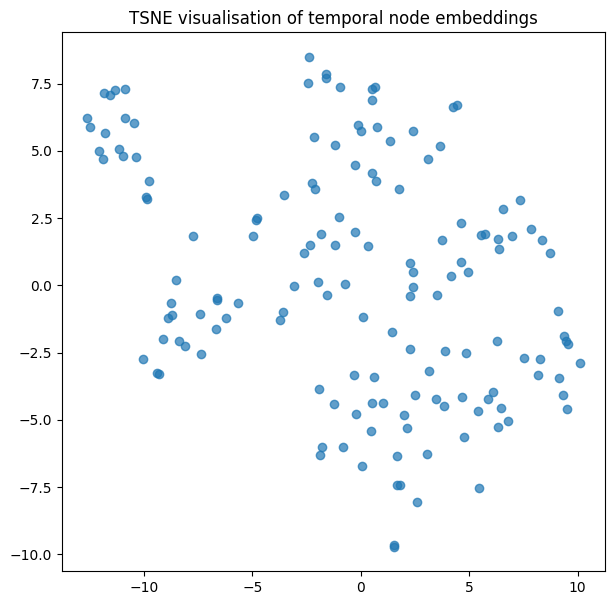

In [ ]:
temporal_node_embeddings = temporal_model.wv.vectors

plot_tsne("TSNE visualisation of temporal node embeddings", temporal_node_embeddings)

In [ ]:
def operator_l2(u, v):
    return (u - v) ** 2


binary_operator = operator_l2

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler


def link_examples_to_features(link_examples, transform_node):
    op_func = (
        operator_func[binary_operator]
        if isinstance(binary_operator, str)
        else binary_operator
    )
    return [
        op_func(transform_node(src), transform_node(dst)) for src, dst in link_examples
    ]


def link_prediction_classifier(max_iter=2000):
    lr_clf = LogisticRegressionCV(Cs=10, cv=10, scoring="roc_auc", max_iter=max_iter)
    return Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])


def evaluate_roc_auc(clf, link_features, link_labels):
    predicted = clf.predict_proba(link_features)

    # check which class corresponds to positive links
    positive_column = list(clf.classes_).index(1)
    return roc_auc_score(link_labels, predicted[:, positive_column])

In [ ]:
def labelled_links(positive_examples, negative_examples):
    return (
        positive_examples + negative_examples,
        np.repeat([1, 0], [len(positive_examples), len(negative_examples)]),
    )


link_examples, link_labels = labelled_links(pos, neg)
link_examples_test, link_labels_test = labelled_links(pos_test, neg_test)

In [ ]:
temporal_clf = link_prediction_classifier()
temporal_link_features = link_examples_to_features(link_examples, temporal_embedding)
temporal_link_features_test = link_examples_to_features(
    link_examples_test, temporal_embedding
)
temporal_clf.fit(temporal_link_features, link_labels)
temporal_score = evaluate_roc_auc(
    temporal_clf, temporal_link_features_test, link_labels_test
)

print(f"Score (ROC AUC): {temporal_score:.2f}")

Score (ROC AUC): 0.96
